# Developer tutorial: ABM examples

This tutorial describes how Starsim can be used to reproduce examples from other Python ABMs.


## `agentpy`: Virus spread

This tutorial is adapted from the following example:
https://agentpy.readthedocs.io/en/latest/agentpy_virus_spread.html

TBC

## Mesa: Wealth model

Although Starsim is intended primarily for modeling disease, it can also be used as a general-purpose agent-based model.  This example illustrates a simple "weath model", in which each agent starts with a single unit of wealth, and on each timestep, every agent with more than zero wealth gives one unit of wealth to another agent.

This tutorial is adapted from the following example:

https://mesa.readthedocs.io/en/stable/tutorials/intro_tutorial.html

### Setting up the agents

All we need to do is define a single new state for the people, namely `wealth`:
```python
wealth = ss.FloatArr('wealth', default=1.0)
people = ss.People(n_agents=n_agents, extra_states=wealth)
```

(Note that we're using a `FloatArr` here even though wealth is an integer in this model; this is because float arrays, unlike integer arrays, can handle missing values, and in most cases are interchangeable. If you really need an integer array, you can use `ss.Arr(dtype=int)`.)


### Setting up the model

Although we could define wealth as a subclass `ss.Disease`, it is slightly less political to define it as a subclass of `ss.Intervention`. All we need to do is update the `wealth` state, but we can also use this class to track the wealth distribution over time and plot it. The full model, including the people, looks like this:

Initializing sim with 100 agents
  Running 0.0 ( 0/101) (0.01 s)  ———————————————————— 1%
  Running 10.0 (10/101) (0.01 s)  ••—————————————————— 11%
  Running 20.0 (20/101) (0.01 s)  ••••———————————————— 21%
  Running 30.0 (30/101) (0.01 s)  ••••••—————————————— 31%
  Running 40.0 (40/101) (0.02 s)  ••••••••———————————— 41%
  Running 50.0 (50/101) (0.03 s)  ••••••••••—————————— 50%
  Running 60.0 (60/101) (0.03 s)  ••••••••••••———————— 60%
  Running 70.0 (70/101) (0.04 s)  ••••••••••••••—————— 70%
  Running 80.0 (80/101) (0.05 s)  ••••••••••••••••———— 80%
  Running 90.0 (90/101) (0.05 s)  ••••••••••••••••••—— 90%
  Running 100.0 (100/101) (0.05 s)  •••••••••••••••••••• 100%



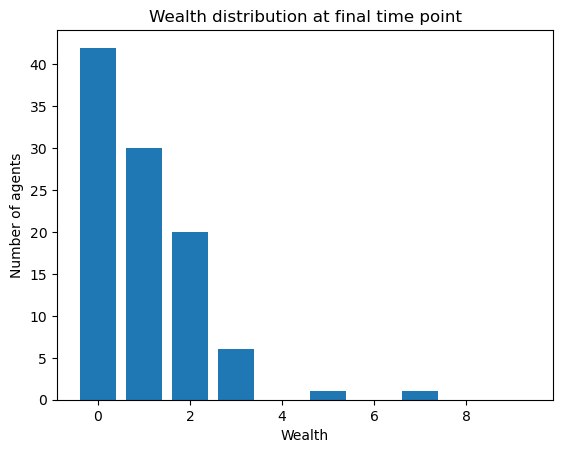

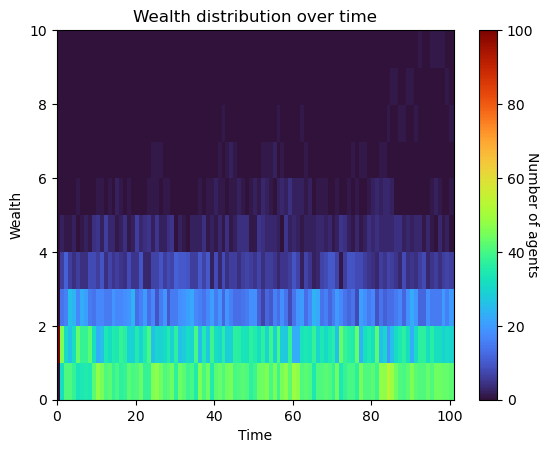

In [7]:
# Imports
import numpy as np
import starsim as ss
import matplotlib.pyplot as plt

# Define the model
class WealthModel(ss.Intervention):
    """ A simple wealth transfer model"""
    
    def init_post(self, bins=10):
        """ Define custom model attributes """
        super().init_post()
        self.npts = self.sim.npts
        self.n_agents = len(sim.people)
        self.bins = np.arange(bins+1)
        self.wealth_dist = np.zeros((self.npts, len(self.bins)-1))
        return
        
    def apply(self, sim):
        """ Transfer wealth between agents """
        self.wealth_hist()
        givers = (sim.people.wealth > 0).uids
        receivers = ss.uids(np.random.choice(sim.people.uid, size=len(givers)))
        sim.people.wealth[givers] -= 1
        for receive in receivers: # Vectorized version is: np.add.at(sim.people.wealth.raw, receivers, 1)
            sim.people.wealth[receive] += 1
        return
    
    def wealth_hist(self):
        """ Calculate the wealth histogram """
        ti = self.sim.ti # Current timestep
        wealth = self.sim.people.wealth # Current wealth
        self.wealth_dist[ti,:], _ = np.histogram(wealth, bins=self.bins)
        return
    
    def plot(self):
        """ Plot a 2D histogram of the final wealth distribution """
        plt.figure()
        plt.bar(self.bins[:-1], self.wealth_dist[-1,:])
        plt.title('Wealth distribution at final time point')
        plt.xlabel('Wealth')
        plt.ylabel('Number of agents')
        plt.show()
        return
    
    def plot3d(self):
        """ Plot a 3D heatmap of the wealth distribution over time """
        plt.figure()
        plt.pcolor(self.wealth_dist.T, cmap='turbo')
        plt.title('Wealth distribution over time')
        plt.xlabel('Time')
        plt.ylabel('Wealth')
        plt.colorbar().set_label('Number of agents', rotation=270)
        plt.show()
        return
    
# Create the People object with a custom wealth state
n_agents = 100
wealth = ss.FloatArr('wealth', default=1.0)
people = ss.People(n_agents=n_agents, extra_states=wealth)

# Create sim inputs, including the wealth model
wealth = WealthModel()
pars = dict(
    start = 0,
    end = 100,
    people = people,
    interventions = wealth,
)

# Run and plot the model
sim = ss.Sim(pars, copy_inputs=False)
sim.run()
wealth.plot()
wealth.plot3d()

### Comparison with Mesa

While the implementation in Starsim is similar to Mesa, there are a couple key differences:
- Because Starsim's people object is vectorized, the wealth definition and update is vectorized as well